In [ ]:
# This is Final Exam for IBM Time Series course.
# I use monthly vw market data.

In [41]:
!pip install statsmodels==0.11.0
!pip install pmdarima

     |████████████████████████████████| 8.7 MB 1.8 MB/s            
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.1
    Uninstalling statsmodels-0.13.1:
      Successfully uninstalled statsmodels-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.19.0 requires statsmodels>=0.13, but you have statsmodels 0.11.0 which is incompatible.
plotnine 0.8.0 requires statsmodels>=0.12.1, but you have statsmodels 0.11.0 which is incompatible.
     |████████████████████████████████| 1.4 MB 285 kB/s            


In [22]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
plt.style.use('seaborn-white')

In [12]:
path = '../input/monthly-market-returns/mMKT.CSV'
df = pd.read_csv(path)
df.shape

(1146, 2)

In [36]:
df.head()

,mkt
date,
1926-07,2.96
1926-08,2.64
1926-09,0.36
1926-10,-3.24
1926-11,2.53


In [14]:
df.date=pd.to_datetime(df.date,format='%Y%m')
df.date=df.date.dt.strftime("%Y-%m")

In [15]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1146 entries, 1926-07 to 2021-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mkt     1146 non-null   float64
dtypes: float64(1)
memory usage: 17.9+ KB


<AxesSubplot:xlabel='date', ylabel='mkt'>

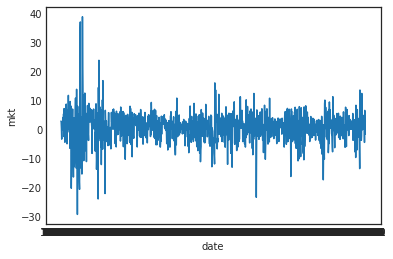

In [23]:
df.describe()
sns.lineplot(x=df.index, y='mkt', data=df)

In [24]:
# testing stationarity and seasonality
import statsmodels.tsa.stattools as ts

results = ts.adfuller(df)
results
# ts is stationary.

(-8.299754730569054,
 4.0482698873981886e-13,
 20,
 1125,
 {'1%': -3.4361760299117914,
  '5%': -2.8641125290596436,
  '10%': -2.5681396861234567},
 6931.732739371823)

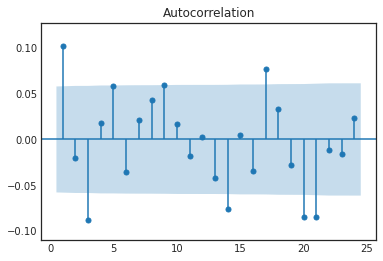

In [38]:
# forecasting using ARIMA

# first, see acf/pacf

sm.tsa.graphics.plot_acf(df.mkt, lags=24, zero=False, auto_ylims=True);

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


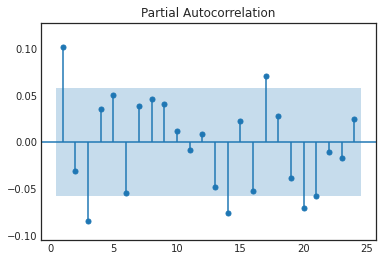

In [39]:
sm.tsa.graphics.plot_pacf(df.mkt, lags=24, zero=False, auto_ylims=True);

In [47]:
# try to autodetect arima order, use this: https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

arima_model = auto_arima(train, start_p=0, start_q=0, d=0, max_p=5, max_d=0, max_q=5, seasonal=False, n_fits=50, steepwise=False)
arima_model

In [51]:
arima_model.predict(n_periods=20)

array([0.41215995, 0.67847436, 0.67847436, 0.67847436, 0.67847436,
       0.67847436, 0.67847436, 0.67847436, 0.67847436, 0.67847436,
       0.67847436, 0.67847436, 0.67847436, 0.67847436, 0.67847436,
       0.67847436, 0.67847436, 0.67847436, 0.67847436, 0.67847436])

In [54]:
forecast = arima_model.predict(start=df.index[200], end=df.index[-1])
forecast

array([0.41215995, 0.67847436, 0.67847436, 0.67847436, 0.67847436,
       0.67847436, 0.67847436, 0.67847436, 0.67847436, 0.67847436])

In [53]:
# I need rolling forecast. can take code from here: https://www.kaggle.com/redwankarimsony/time-series-forecasting-with-arima#Rolling-Forecast-ARIMA-Model




'2021-12'

In [ ]:
# forecasting using RNN

In [ ]:
# forecasting using LSTM

In [ ]:
# forecasting using transformer?

In [37]:
df.mkt

date
1926-07    2.96
1926-08    2.64
1926-09    0.36
1926-10   -3.24
1926-11    2.53
           ... 
2021-08    2.90
2021-09   -4.37
2021-10    6.65
2021-11   -1.55
2021-12    3.10
Name: mkt, Length: 1146, dtype: float64